In [1]:
# 深度学习的训练过程常常非常耗时，一个模型训练几个小时是家常便饭，

# 训练几天也是常有的事情，有时候甚至要训练几十天。

# 训练过程的耗时主要来自于两个部分，一部分来自数据准备，另一部分来自参数迭代。

# 当数据准备过程还是模型训练时间的主要瓶颈时，我们可以使用更多进程来准备数据。

# 当参数迭代过程成为训练时间的主要瓶颈时，我们通常的方法是应用GPU来进行加速。

# Pytorch中使用GPU加速模型非常简单，只要将模型和数据移动到GPU上。核心代码只有以下几行。

In [2]:
# 定义模型
# ... 

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device) # 移动模型到cuda

# 训练模型
# ...

# features = features.to(device) # 移动数据到cuda
# labels = labels.to(device) 
# 或者  labels = labels.cuda() if torch.cuda.is_available() else labels
# ...

In [3]:
# 如果要使用多个GPU训练模型，也非常简单。只需要在将模型设置为数据并行风格模型。

# 则模型移动到GPU上之后，会在每一个GPU上拷贝一个副本，

# 并把数据平分到各个GPU上进行训练。核心代码如下。

# #定义模型
# ... 

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model) # 包装为并行风格模型

# # 训练模型
# ...
# features = features.to(device) # 移动数据到cuda
# labels = labels.to(device) # 或者 labels = labels.cuda() if torch.cuda.is_available() else labels
# ...

In [4]:
import torch 
from torch import nn 

In [5]:
# 1，查看gpu信息
if_cuda = torch.cuda.is_available()
print("if_cuda=",if_cuda)

gpu_count = torch.cuda.device_count()
print("gpu_count=",gpu_count)

if_cuda= True
gpu_count= 1


In [6]:
# 2，将张量在gpu和cpu间移动
tensor = torch.rand((100,100))
tensor_gpu = tensor.to("cuda:0") # 或者 tensor_gpu = tensor.cuda()
print(tensor_gpu.device)
print(tensor_gpu.is_cuda)

tensor_cpu = tensor_gpu.to("cpu") # 或者 tensor_cpu = tensor_gpu.cpu() 
print(tensor_cpu.device)

cuda:0
True
cpu


In [7]:
# 3，将模型中的全部张量移动到gpu上
net = nn.Linear(2,1)
print(next(net.parameters()).is_cuda)
net.to("cuda:0") # 将模型中的全部参数张量依次到GPU上，注意，无需重新赋值为 net = net.to("cuda:0")
print(next(net.parameters()).is_cuda)
print(next(net.parameters()).device)

False
True
cuda:0


In [8]:
# 4，创建支持多个gpu数据并行的模型
linear = nn.Linear(2,1)
print(next(linear.parameters()).device)

model = nn.DataParallel(linear)
print(model.device_ids)
print(next(model.module.parameters()).device) 

#注意保存参数时要指定保存model.module的参数
torch.save(model.module.state_dict(), "../data/model_parameter.pkl") 

linear = nn.Linear(2,1)
linear.load_state_dict(torch.load("../data/model_parameter.pkl")) 

cpu
[0]
cuda:0


<All keys matched successfully>

In [9]:
# 5，清空cuda缓存

# 该方法在cuda超内存时十分有用
torch.cuda.empty_cache()

In [10]:
# 一，矩阵乘法范例
# 下面分别使用CPU和GPU作一个矩阵乘法，并比较其计算效率。

In [11]:
import time
import torch 
from torch import nn

In [12]:
# 使用cpu
a = torch.rand((10000,200))
b = torch.rand((200,10000))
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()

print(toc-tic)
print(a.device)
print(b.device)

0.34841442108154297
cpu
cpu


In [15]:
# 使用gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a = torch.rand((10000,200),device = device) #可以指定在GPU上创建张量
b = torch.rand((200,10000)) #也可以在CPU上创建张量后移动到GPU上
b = b.to(device) #或者 b = b.cuda() if torch.cuda.is_available() else b 
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()
print(toc-tic)
print(a.device)
print(b.device)

0.012966394424438477
cuda:0
cuda:0


In [14]:
# 二，线性回归范例
# 下面对比使用CPU和GPU训练一个线性回归模型的效率

In [37]:
# 1，使用CPU

In [16]:
# 准备数据
n = 1000000 #样本数量

X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

In [17]:
# 定义模型
class LinearRegression(nn.Module): 
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x): 
        return x@self.w.t() + self.b
        
linear = LinearRegression() 

In [18]:
# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_func = nn.MSELoss()

def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X) 
        loss = loss_func(Y_pred,Y)
        loss.backward() 
        optimizer.step()
        if epoch%50==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)

train(500)

{'epoch': 0, 'loss': 220.96922302246094}
{'epoch': 50, 'loss': 33.42723846435547}
{'epoch': 100, 'loss': 9.046113967895508}
{'epoch': 150, 'loss': 4.4932403564453125}
{'epoch': 200, 'loss': 4.025519847869873}
{'epoch': 250, 'loss': 4.001718521118164}
{'epoch': 300, 'loss': 4.001194953918457}
{'epoch': 350, 'loss': 4.00119161605835}
{'epoch': 400, 'loss': 4.00119161605835}
{'epoch': 450, 'loss': 4.00119161605835}
time used: 8.018563747406006


In [19]:
# 2，使用GPU

In [20]:
# 准备数据
n = 1000000 #样本数量

X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

# 移动到GPU上
print("torch.cuda.is_available() = ",torch.cuda.is_available())
X = X.cuda()
Y = Y.cuda()
print("X.device:",X.device)
print("Y.device:",Y.device)

torch.cuda.is_available() =  True
X.device: cuda:0
Y.device: cuda:0


In [21]:
# 定义模型
class LinearRegression(nn.Module): 
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x): 
        return x@self.w.t() + self.b
        
linear = LinearRegression() 

# 移动模型到GPU上
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
linear.to(device)

#查看模型是否已经移动到GPU上
print("if on cuda:",next(linear.parameters()).is_cuda)

if on cuda: True


In [22]:
# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_func = nn.MSELoss()

def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X) 
        loss = loss_func(Y_pred,Y)
        loss.backward() 
        optimizer.step()
        if epoch%50==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)
    
train(500)

{'epoch': 0, 'loss': 127.64462280273438}
{'epoch': 50, 'loss': 32.8957405090332}
{'epoch': 100, 'loss': 9.042280197143555}
{'epoch': 150, 'loss': 4.491191864013672}
{'epoch': 200, 'loss': 4.023579120635986}
{'epoch': 250, 'loss': 3.9997875690460205}
{'epoch': 300, 'loss': 3.99926495552063}
{'epoch': 350, 'loss': 3.9992613792419434}
{'epoch': 400, 'loss': 3.9992613792419434}
{'epoch': 450, 'loss': 3.9992613792419434}
time used: 1.2172436714172363


In [23]:
# 由此看来GPU真的比CPU效率高很多！

In [24]:
# 三，torchkeras使用单GPU范例

# 下面使用torchkeras来应用GPU训练模型的方法。

# 其对应的CPU训练模型代码参见《6-2,训练模型的3种方法》

# 本例仅需要在它的基础上增加一行代码，在model.compile时指定 device即可。

In [25]:
import torch 
from torch import nn 

import torchvision 
from torchvision import transforms

import torchkeras 

In [26]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="../data/minist/",train=True,download=True,transform=transform)
ds_valid = torchvision.datasets.MNIST(root="../data/minist/",train=False,download=True,transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid =  torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False, num_workers=4)

print(len(ds_train))
print(len(ds_valid))

60000
10000


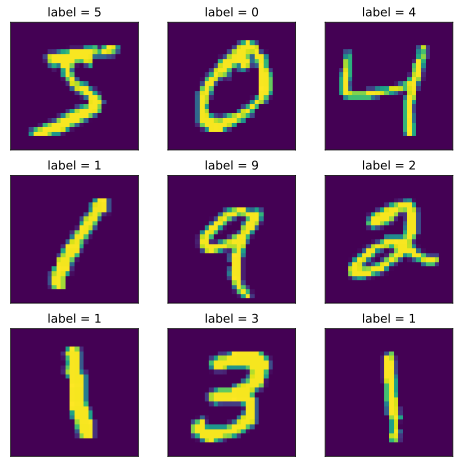

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [28]:
# 2，定义模型

In [29]:
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

#PinPoint！！！！


net = CnnModel()
model = torchkeras.Model(net)
model.summary(input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [30]:
# 3，训练模型

In [31]:
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.cpu().numpy(),y_pred_cls.cpu().numpy()) 
    # 注意此处要将数据先移动到cpu上，然后才能转换成numpy数组

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.compile(loss_func = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy},device = device) # 注意此处compile时指定了device

dfhistory = model.fit(3,dl_train = dl_train, dl_val=dl_valid, log_step_freq=100) 

Start Training ...

================================================================================2021-10-06 23:21:03
{'step': 100, 'loss': 1.129, 'accuracy': 0.604}
{'step': 200, 'loss': 0.7, 'accuracy': 0.761}
{'step': 300, 'loss': 0.532, 'accuracy': 0.821}
{'step': 400, 'loss': 0.439, 'accuracy': 0.854}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.398 |  0.868   |   0.1    |    0.969     |
+-------+-------+----------+----------+--------------+

================================================================================2021-10-06 23:21:30
{'step': 100, 'loss': 0.178, 'accuracy': 0.948}
{'step': 200, 'loss': 0.18, 'accuracy': 0.947}
{'step': 300, 'loss': 0.169, 'accuracy': 0.951}
{'step': 400, 'loss': 0.171, 'accuracy': 0.95}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-

In [32]:
# 4，评估模型

In [33]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

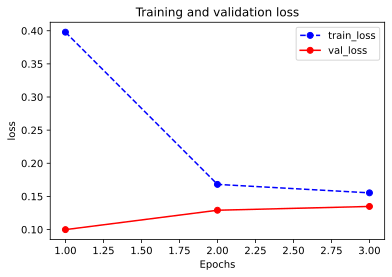

In [34]:
plot_metric(dfhistory,"loss")

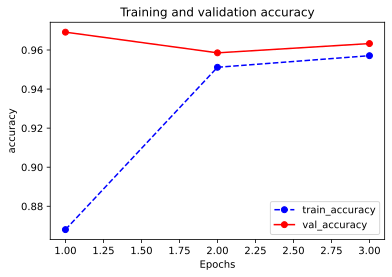

In [35]:
plot_metric(dfhistory,"accuracy")

In [36]:
model.evaluate(dl_valid)

{'val_loss': 0.13482357057613098, 'val_accuracy': 0.963310917721519}

In [37]:
# 5，使用模型

In [38]:
model.predict(dl_valid)[0:10]

tensor([[ -7.1784,   2.3611,   3.1782,   6.1605,  -3.9647,   5.8528, -19.3140,
          24.2139,  -4.4958,   4.5228],
        [ -0.8245,   3.4876,   9.8943,  -2.8131,   3.6956,  -0.4353,   3.5125,
           1.5414,   1.5344,   2.6772],
        [-11.5757,  16.3203,   6.7991,   5.6841,   1.5525,  -7.7881,   4.5393,
           5.5377,  -0.7560, -13.5974],
        [ 12.0613,  -0.8702,  -2.3096,   1.7370,  -0.0744,  -5.0691,   2.1874,
          -8.6742,   2.0380,   8.0070],
        [ -6.8131,   6.2957,  -3.4063,  -4.0321,  20.5698,  -6.6784,  -3.7760,
           7.6624,  -1.7325,   4.0901],
        [-16.9260,  23.1153,   9.4856,   9.5391,   2.2878, -11.3990,   6.6285,
           6.9159,  -0.5841, -19.4414],
        [ -5.8168,   4.9720,  -3.6157,  -2.8751,  18.9353,  -5.5880,  -5.3741,
           7.8887,  -1.4362,   5.4194],
        [  1.5647,  -3.0348,  -2.6775,   3.4953,   2.4855,   1.9100,  -9.7725,
           4.9020,   0.7734,   8.3808],
        [  4.2245,  -0.8190,  -0.3983,  -2.8937,

In [39]:
# 6，保存模型

In [40]:
# save the model parameters
torch.save(model.state_dict(), "model_parameter.pkl")

model_clone = torchkeras.Model(CnnModel())
model_clone.load_state_dict(torch.load("model_parameter.pkl"))

model_clone.compile(loss_func = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy},device = device) # 注意此处compile时指定了device

model_clone.evaluate(dl_valid)

{'val_loss': 0.13482357057613098, 'val_accuracy': 0.963310917721519}

In [41]:
# 四，torchkeras使用多GPU范例
# 注：以下范例需要在有多个GPU的机器上跑。
# 如果在单GPU的机器上跑，也能跑通，但是实际上使用的是单个GPU。